In [1]:
import pandas as pd
import random

def downsample_dataset(input_file, output_file, target_sample_size):
    # Load the entire dataset into a DataFrame
    df = pd.read_csv('Sentiment_Data.csv', encoding='latin-1')

    # Calculate the original size of the dataset
    original_size = len(df)

    if target_sample_size >= original_size:
        print("Target sample size is greater than or equal to the original size. No downsampling needed.")
        df.to_csv(output_file, index=False)
        return

    # Calculate the probability for each record to be included in the downsampled dataset
    probability = target_sample_size / original_size

    # Generate a random number for each record and include it if it falls below the probability threshold
    random.seed(42)  # Setting a seed for reproducibility
    mask = [random.random() < probability for _ in range(original_size)]

    # Apply the mask to the DataFrame to get the downsampled dataset
    downsampled_df = df[mask]

    # Save the downsampled dataset to a new CSV file
    downsampled_df.to_csv(output_file, index=False)

    print(f"Downsampling completed. Original size: {original_size}, Target size: {target_sample_size}")

# Example usage:
input_file_path = 'Sentiment_Data.csv'
output_file_path = 'downsampled_dataset.csv'
target_sample_size = 10000

downsample_dataset(input_file_path, output_file_path, target_sample_size)


Downsampling completed. Original size: 451332, Target size: 10000


In [2]:
import nltk
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize






In [3]:
import pandas as pd

# Load the dataset into a DataFrame (replace 'path/to/dataset.csv' with your file path)
df = pd.read_csv('downsampled_dataset.csv')


In [4]:
# Basic exploration of the DataFrame
df.head(5)
df.columns
print(len(df))
df.shape
df.info()
df.dtypes
np.sum(df.isnull().any(axis=1))
df['Tweet'].unique()
df['Sentiment'].unique()
df['Tweet'].nunique()
df['Sentiment'].nunique()
df_string = df['Tweet'].to_string(index=False)


9927
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9927 entries, 0 to 9926
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      9927 non-null   object
 1   Sentiment  9927 non-null   object
dtypes: object(2)
memory usage: 155.2+ KB


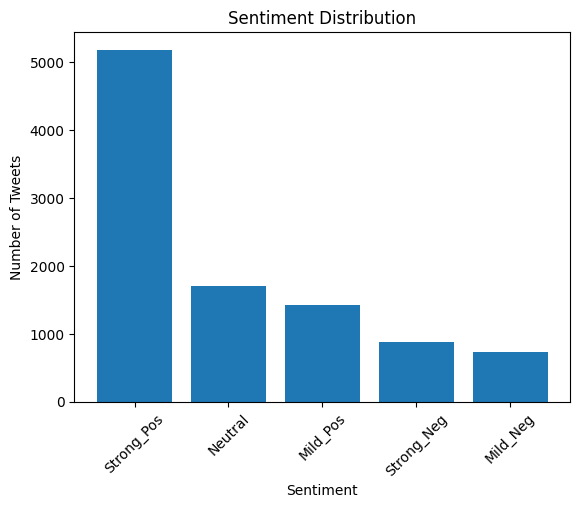

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Number of tweets for each sentiment
sentiment_counts = df['Sentiment'].value_counts()

# Create a bar chart
plt.bar(sentiment_counts.index, sentiment_counts.values)

plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

plt.show()

In [6]:
# Preprocessing - Step 1: Removing non-alphabetic characters
df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', ' ', str(x)))

# Preprocessing - Step 2: Removing URLs
df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', ' ', str(x)))

# Preprocessing - Step 3: Removing excessive whitespace
df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r'\s+', ' ', str(x)).strip())


In [7]:
# Tokenization
df['tokens'] = df['Tweet'].apply(lambda x: word_tokenize(str(x)))

# Converting tokens to lowercase
df['tokens'] = df['tokens'].apply(lambda tokens: [token.lower() for token in tokens])

# Removing stopwords
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda tokens: [token for token in tokens if token not in stop_words])

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])


In [8]:
# Sentiment mapping
sentiment_mapping = {
    'Strong_Pos': 1,
    'Strong_Neg': -1,
    'Mild_Pos': 0.5,
    'Mild_Neg': -0.5,
    'Neutral': 0
}
df['sentiment_encoded'] = df['Sentiment'].map(sentiment_mapping)

# Print the resulting DataFrame
print(df[['Tweet', 'tokens', 'Sentiment', 'sentiment_encoded']].head())


                                               Tweet  \
0  DavidKrayden Happy Anniversary The Day the Fre...   
1      CdnFreedomGirl We love the convoy for freedom   
2  Freedom Convoy HIGHLIGHTS Honking Machine on P...   
3  TamaraUgo Everything that they publish They al...   
4  true the noisy few FreedomConvoy freedomconvoy...   

                                              tokens   Sentiment  \
0  [davidkrayden, happy, anniversary, day, freedu...    Mild_Pos   
1            [cdnfreedomgirl, love, convoy, freedom]  Strong_Pos   
2  [freedom, convoy, highlight, honking, machine,...  Strong_Pos   
3  [tamaraugo, everything, publish, also, never, ...  Strong_Pos   
4  [true, noisy, freedomconvoy, freedomconvoy, th...     Neutral   

   sentiment_encoded  
0                0.5  
1                1.0  
2                1.0  
3                1.0  
4                0.0  


In [9]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder


In [10]:
# Clean the text 
def clean_text(text):
    # Remove special characters and website link
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # removewhitespace
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['Tweet'] = df['Tweet'].apply(clean_text)




# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Tweet'], df['Sentiment'], test_size=0.2, random_state=42)



In [11]:
# Perform tfidf vectorizer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [12]:
# Encodsentiment labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, GRU, Bidirectional, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score

In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Tweet'], df['Sentiment'], test_size=0.2, random_state=42)

In [15]:
# Encode the sentiment labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [16]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [17]:
# Pad sequences
max_seq_length = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq_length)

In [18]:
#Build gru
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 100, input_length=max_seq_length))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(Bidirectional(GRU(64)))
model.add(Dense(label_encoder.classes_.shape[0], activation='softmax'))

In [19]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
# Train the model
model.fit(X_train_padded, y_train_encoded, epochs=10, batch_size=32)

Epoch 1/10
249/249 [==============================] - 9s 31ms/step - loss: 1.2302 - accuracy: 0.5533
Epoch 2/10
249/249 [==============================] - 8s 32ms/step - loss: 0.8090 - accuracy: 0.6890
Epoch 3/10
249/249 [==============================] - 8s 32ms/step - loss: 0.3918 - accuracy: 0.8597
Epoch 4/10
249/249 [==============================] - 8s 33ms/step - loss: 0.1657 - accuracy: 0.9446
Epoch 5/10
249/249 [==============================] - 8s 33ms/step - loss: 0.0775 - accuracy: 0.9754
Epoch 6/10
249/249 [==============================] - 9s 34ms/step - loss: 0.0422 - accuracy: 0.9872
Epoch 7/10
249/249 [==============================] - 9s 35ms/step - loss: 0.0319 - accuracy: 0.9898
Epoch 8/10
249/249 [==============================] - 9s 37ms/step - loss: 0.0237 - accuracy: 0.9932
Epoch 9/10
249/249 [==============================] - 9s 35ms/step - loss: 0.0123 - accuracy: 0.9962
Epoch 10/10
249/249 [==============================] - 8s 33ms/step - loss: 0.0147 - accura

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Predict sentiment probabilities for the test set
y_pred_prob = model.predict(X_test_padded)

# Convert probabilities to class labels
y_pred_labels = label_encoder.inverse_transform(y_pred_prob.argmax(axis=1))

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels, average='macro')
recall = recall_score(y_test, y_pred_labels, average='macro')
f1 = f1_score(y_test, y_pred_labels, average='macro')
confusion_mat = confusion_matrix(y_test, y_pred_labels)

# Print the evaluation metrics and confusion matrix
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(confusion_mat)

63/63 [==============================] - 1s 9ms/step
Accuracy: 0.5206445115810675
Precision: 0.39537307375752395
Recall: 0.37615189331221427
F1-score: 0.3758152041155296
Confusion Matrix:
[[ 15  32  37  26  29]
 [  9  78  89  14  98]
 [ 10  50 152  22  86]
 [ 15  31  55  63  23]
 [ 13 151 141  21 726]]


In [22]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, MultiHeadAttention, LayerNormalization
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score


In [23]:
def build_transformer_model(max_seq_length, vocab_size):
    input_layer = Input(shape=(max_seq_length,))
    embedding_layer = Embedding(vocab_size, 100)(input_layer)
    attention_layer = MultiHeadAttention(num_heads=4, key_dim=100, dropout=0.2)(embedding_layer, embedding_layer, embedding_layer)
    attention_layer = LayerNormalization()(attention_layer)
    attention_layer = tf.keras.layers.Flatten()(attention_layer)
    output_layer = Dense(len(label_encoder.classes_), activation='softmax')(attention_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [24]:
# Read the dataset
df = pd.read_csv('downsampled_dataset.csv', encoding='latin-1')

# Handle missing values in the 'Tweet' column
df['Tweet'].fillna('', inplace=True)


In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Tweet'], df['Sentiment'], test_size=0.2, random_state=42)


In [26]:
# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [27]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


In [28]:
# Pad sequences
max_seq_length = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq_length)


In [29]:
# Create an input layer for the model
input_layer = Input(shape=(max_seq_length,))


In [30]:
# Add the embedding layer
embedding_layer = Embedding(len(tokenizer.word_index) + 1, 100)(input_layer)


In [31]:
# Add the MultiHeadAttention layer
attention_layer = MultiHeadAttention(num_heads=4, key_dim=100, dropout=0.2)(embedding_layer, embedding_layer, embedding_layer)


In [32]:
# Add LayerNormalization
attention_layer = LayerNormalization()(attention_layer)


In [33]:
# Flatten the attention output
attention_layer = tf.keras.layers.Flatten()(attention_layer)


In [34]:
# Add the output layer
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(attention_layer)


In [35]:
# Create the Attention/Transformer model
model_transformer = Model(inputs=input_layer, outputs=output_layer)


In [36]:
# Compile the model
model_transformer.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [37]:
# Train the model
batch_size = 32
model_transformer.fit(X_train_padded, y_train_encoded, epochs=10, batch_size=batch_size)


Epoch 1/10
249/249 [==============================] - 7s 26ms/step - loss: 1.1949 - accuracy: 0.5624
Epoch 2/10
249/249 [==============================] - 7s 28ms/step - loss: 0.7932 - accuracy: 0.6984
Epoch 3/10
249/249 [==============================] - 7s 28ms/step - loss: 0.4257 - accuracy: 0.8457
Epoch 4/10
249/249 [==============================] - 7s 28ms/step - loss: 0.1647 - accuracy: 0.9435
Epoch 5/10
249/249 [==============================] - 7s 28ms/step - loss: 0.0614 - accuracy: 0.9810
Epoch 6/10
249/249 [==============================] - 7s 29ms/step - loss: 0.0389 - accuracy: 0.9895
Epoch 7/10
249/249 [==============================] - 8s 30ms/step - loss: 0.0162 - accuracy: 0.9955
Epoch 8/10
249/249 [==============================] - 7s 28ms/step - loss: 0.0319 - accuracy: 0.9903
Epoch 9/10
249/249 [==============================] - 7s 28ms/step - loss: 0.0996 - accuracy: 0.9743
Epoch 10/10
249/249 [==============================] - 7s 28ms/step - loss: 0.0657 - accura

In [38]:
# Evaluate the Attention/Transformer model
y_pred_transformer_prob = model_transformer.predict(X_test_padded)
y_pred_transformer = y_pred_transformer_prob.argmax(axis=-1)


63/63 [==============================] - 1s 9ms/step


In [39]:
# Calculate evaluation metrics for the Attention/Transformer model
accuracy_transformer = accuracy_score(y_test_encoded, y_pred_transformer)
precision_transformer = precision_score(y_test_encoded, y_pred_transformer, average='macro')
recall_transformer = recall_score(y_test_encoded, y_pred_transformer, average='macro')
f1_transformer = f1_score(y_test_encoded, y_pred_transformer, average='macro')
confusion_mat_transformer = confusion_matrix(y_test_encoded, y_pred_transformer)
auc_score_transformer = roc_auc_score(y_test_encoded, y_pred_transformer_prob, multi_class='ovo')


In [40]:
# Print Attention/Transformer model performance metrics
print("\nAttention/Transformer Model Metrics:")
print("Accuracy:", accuracy_transformer)
print("Precision:", precision_transformer)
print("Recall:", recall_transformer)
print("F1-score:", f1_transformer)
print("Confusion Matrix:")
print(confusion_mat_transformer)
print("AUC Score:", auc_score_transformer)



Attention/Transformer Model Metrics:
Accuracy: 0.5961732124874118
Precision: 0.4189117746330135
Recall: 0.3986673440572891
F1-score: 0.38986552097599475
Confusion Matrix:
[[ 37   4  42  29  27]
 [ 22  15  53  19 179]
 [ 36   7 140  18 119]
 [ 44   6  37  67  33]
 [ 26  21  64  16 925]]
AUC Score: 0.7026774444930516


In [42]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, MultiHeadAttention, LayerNormalization, LSTM
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

In [43]:
# Build the RNN/LSTM model
model_rnn = Sequential()
model_rnn.add(Embedding(len(tokenizer.word_index) + 1, 100, input_length=max_seq_length))
model_rnn.add(Bidirectional(LSTM(64)))
model_rnn.add(Dense(len(label_encoder.classes_), activation='softmax'))

In [44]:
# Compile the RNN/LSTM model
model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
# Train the RNN/LSTM model
model_rnn.fit(X_train_padded, y_train_encoded, epochs=10, batch_size=batch_size)

Epoch 1/10
249/249 [==============================] - 6s 20ms/step - loss: 1.1882 - accuracy: 0.5689
Epoch 2/10
249/249 [==============================] - 5s 21ms/step - loss: 0.8137 - accuracy: 0.6834
Epoch 3/10
249/249 [==============================] - 5s 22ms/step - loss: 0.4975 - accuracy: 0.8109
Epoch 4/10
249/249 [==============================] - 5s 21ms/step - loss: 0.2929 - accuracy: 0.9006
Epoch 5/10
249/249 [==============================] - 6s 22ms/step - loss: 0.1499 - accuracy: 0.9516
Epoch 6/10
249/249 [==============================] - 5s 21ms/step - loss: 0.0677 - accuracy: 0.9805
Epoch 7/10
249/249 [==============================] - 5s 21ms/step - loss: 0.0315 - accuracy: 0.9926
Epoch 8/10
249/249 [==============================] - 5s 21ms/step - loss: 0.0202 - accuracy: 0.9946
Epoch 9/10
249/249 [==============================] - 5s 21ms/step - loss: 0.0175 - accuracy: 0.9962
Epoch 10/10
249/249 [==============================] - 5s 21ms/step - loss: 0.0148 - accura

In [51]:
# Predict sentiment labels for the test set using RNN/LSTM model
y_pred_rnn_prob = model_rnn.predict(X_test_padded)
y_pred_rnn = y_pred_rnn_prob.argmax(axis=-1)

63/63 [==============================] - 0s 5ms/step


In [52]:
# Evaluate the RNN/LSTM model
accuracy_rnn = accuracy_score(y_test_encoded, y_pred_rnn)
precision_rnn = precision_score(y_test_encoded, y_pred_rnn, average='macro')
recall_rnn = recall_score(y_test_encoded, y_pred_rnn, average='macro')
f1_rnn = f1_score(y_test_encoded, y_pred_rnn, average='macro')
confusion_mat_rnn = confusion_matrix(y_test_encoded, y_pred_rnn)
auc_score_rnn = roc_auc_score(y_test_encoded, y_pred_rnn_prob, multi_class='ovo')

In [53]:
# Print performance metrics for both models
print("\nRNN/LSTM Model Metrics:")
print("Accuracy:", accuracy_rnn)
print("Precision:", precision_rnn)
print("Recall:", recall_rnn)
print("F1-score:", f1_rnn)
print("Confusion Matrix:")
print(confusion_mat_rnn)
print("AUC Score:", auc_score_rnn)

print("\nAttention/Transformer Model Metrics:")
print("Accuracy:", accuracy_transformer)
print("Precision:", precision_transformer)
print("Recall:", recall_transformer)
print("F1-score:", f1_transformer)
print("Confusion Matrix:")
print(confusion_mat_transformer)
print("AUC Score:", auc_score_transformer)


RNN/LSTM Model Metrics:
Accuracy: 0.5835850956696879
Precision: 0.4265959694846847
Recall: 0.38948370604465976
F1-score: 0.3992012861537763
Confusion Matrix:
[[ 22  30  38  17  32]
 [ 17  67  49  10 145]
 [ 14  48 151  14  93]
 [ 43  21  49  48  26]
 [ 10 103  60   8 871]]
AUC Score: 0.6951345434892136

Attention/Transformer Model Metrics:
Accuracy: 0.5961732124874118
Precision: 0.4189117746330135
Recall: 0.3986673440572891
F1-score: 0.38986552097599475
Confusion Matrix:
[[ 37   4  42  29  27]
 [ 22  15  53  19 179]
 [ 36   7 140  18 119]
 [ 44   6  37  67  33]
 [ 26  21  64  16 925]]
AUC Score: 0.7026774444930516
